In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import urllib
import tensorflow_datasets as tfds

In [2]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


('npy_files/candle.npy', <http.client.HTTPMessage at 0x7ff9e7911c90>)

In [3]:
train_images = np.load(f'npy_files/{category}.npy')
print(f'{len(train_images)} images to train on')
print(np.min(train_images), np.max(train_images))

141545 images to train on
0 255


In [4]:
dataset = tf.data.Dataset.from_tensor_slices(train_images)

def preprocess(data):
    # DATA TYPE
    data = data.map(lambda img: (tf.cast(img, tf.float32)))
    # NORMALIZE
    data = data.map(lambda img: (img/255.))
    # DUPING AND NOISE
    data = data.map(lambda img: (tf.reshape(img, (28, 28, 1))))
    # DATAFLOW PREP
    data = data.cache()
    data = data.shuffle(1000, seed=42)
    data = data.batch(32)
    data = data.prefetch(3)
    return data

dataset = dataset.apply(preprocess)

2023-01-24 19:13:56.605102: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-24 19:13:56.605130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abacus
2023-01-24 19:13:56.605136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abacus
2023-01-24 19:13:56.605203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.56.6
2023-01-24 19:13:56.605222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.56.6
2023-01-24 19:13:56.605227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.56.6
2023-01-24 19:13:56.605493: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

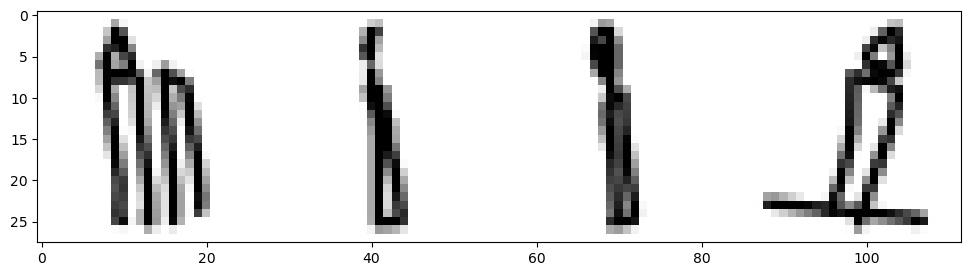

TensorShape([28, 112, 1])

In [143]:
from matplotlib import pyplot as plt
%matplotlib inline

x = next(iter(dataset))

x = tf.concat([x[i, ...] for i in range(4)], axis=1)
plt.figure(figsize=(12, 3))
plt.imshow(x, cmap='binary')
plt.show()
x.shape

In [222]:
class Generator(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense  = tf.keras.layers.Dense(14 * 14 * 128)
        self.shape  = tf.keras.layers.Reshape((14, 14, 128))
        self.conv_1 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='leaky_relu')
        self.conv_2 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=5, strides=2, padding='same', activation='leaky_relu')
        self.norm_0 = tf.keras.layers.BatchNormalization()
        self.conv_3 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=5, padding='same', activation='leaky_relu')
        self.conv_4 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=5, padding='same', activation='leaky_relu')
        self.norm_1 = tf.keras.layers.BatchNormalization()
        self.conv_5 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=5, padding='same', activation='leaky_relu')
        self.conv_6 = tf.keras.layers.SeparableConv2D(filters=256, kernel_size=5, padding='same', activation='leaky_relu')
        self.norm_2 = tf.keras.layers.BatchNormalization()
        self.conv_7 = tf.keras.layers.SeparableConv2D(filters=1, kernel_size=5, padding='same')
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=4e-4, clipvalue=1.0, decay=1e-8)
        
        
    def call(self, batch_size, training=True):
        X = tf.random.normal((batch_size, 256))
        X = self.dense(X)
        X = self.shape(X)
        # 1st BLOCK
        X = self.conv_1(X, training=training)
        Z = self.conv_2(X, training=training)
        X = self.norm_0(Z, training=training)
        # 2nd BLOCK
        X = self.conv_3(X, training=training)
        Z = self.conv_4(X, training=training)
        Z = Z + X
        X = self.norm_1(Z, training=training)
        # 3rd BLOCK
        X = self.conv_5(X, training=training)
        Z = self.conv_6(X, training=training)
        Z = Z + X
        X = self.norm_2(Z, training=training)
        X = self.conv_7(Z, training=training)
        return X
        


class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv_0 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='leaky_relu')
        # (28, 28, 64)
        self.conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', activation='leaky_relu')
        # (14, 14, 64)
        self.conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', activation='leaky_relu')
        # (7, 7, 64)
        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=4, strides=2, padding='same', activation='leaky_relu')
        # (3, 3, 64)
        self.conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='leaky_relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dropout = tf.keras.layers.Dropout(0.4)
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=8e-4, clipvalue=1.0, decay=1e-8)
    
    
    def call(self, X, training=True):
        # Constructing Filterspace
        X = self.conv_0(X, training=training)
        X = self.conv_1(X, training=training)
        X = self.conv_2(X, training=training)
        X = self.conv_3(X, training=training)
        X = self.conv_4(X, training=training)
        # FINALLY
        X = self.flatten(X)
        X = self.dropout(X, training=training)
        P = self.dense(X)
        return P



G = Generator()
D = Discriminator()
n = 3
P = D(G(n))
L = tf.keras.losses.BinaryCrossentropy()(tf.zeros(n), P)
print(P, L)

tf.Tensor(
[[0.5]
 [0.5]
 [0.5]], shape=(3, 1), dtype=float32) tf.Tensor(0.69314694, shape=(), dtype=float32)


In [227]:
import datetime
from tqdm import tqdm
from random import random



class GAN(tf.keras.Model): # aka Adversarial Minmax
    NAME = 'GENERATIVE ADVERSARIAL NETWORK'
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.G = Generator()
        self.D = Discriminator()
        self.is_setup = False
        self.loss = tf.keras.losses.BinaryCrossentropy()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.prev_epochs = 0
    
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    
    def setup(self):
        if self.is_setup:
            return
        # DEFINE PATHSf
        current_time = datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
        train_log_path = f"logs/{self.NAME}{current_time}"
        # CONSTRUCT WRITERS
        self.writer = tf.summary.create_file_writer(train_log_path)
        self.is_setup = True
    
    
    @tf.function
    def call(self, X_true, training=True):
        batch_size = X_true.shape[0]
        X_false = self.G(batch_size, training=training)
        X = tf.concat([X_true, X_false], axis=0)
        P = self.D(X, training=training)
        return P
    
    
    #@tf.function
    def step(self, X_true, training=True):
        batch_size = X_true.shape[0]
        T = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        if training:
            with tf.GradientTape() as tape:
                P = self(X_true, training=training)
                L_D = self.loss(T, P) + tf.random.uniform(P.shape, maxval=0.05)
            nabla_D = tape.gradient(L_D, self.D.trainable_weights)
            self.D.optimizer.apply_gradients(zip(nabla_D, self.D.trainable_weights))
            with tf.GradientTape() as tape:
                P = self(X_true, training=training)
                L_G = -self.loss(T, P)
            nabla_G = tape.gradient(L_G, self.G.trainable_weights)
            self.G.optimizer.apply_gradients(zip(nabla_G, self.G.trainable_weights))
        else:
            P = self(X_true)
            L_D = self.loss(T, P)
        self.loss_metric.update_state(L_D)
        return {metric.name: float(metric.result()) for metric in self.metrics}


    def train(self, dataset, epochs):
        training_metrics = {metric.name: [] for metric in self.metrics}
        testing_metrics = {metric.name: [] for metric in self.metrics}
        self.setup()
        with tqdm(epochs) as bar:
            bar.set_description('TRAINING')
            for epoch in range(epochs):
                # TRAINING
                for X_true in dataset:
                    metrics = self.step(X_true, training=True)
                    for name, value in metrics.items():
                        training_metrics[name].append(value)
                # WRITING METRICS
                with self.writer.as_default():
                    for metric in self.metrics:
                        tf.summary.scalar(metric.name, metric.result(), step=self.prev_epochs)
                    tf.summary.image('Image', self.G(1)[0:])
                self.reset_metrics()
                bar.update(1)
                self.prev_epochs += 1
            metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in self.metrics}
            return metrics

In [228]:
model = GAN()
#model.D.load_weights('discriminator.pd')
model.G.load_weights('generator.pd')
with tf.device('GPU'):
    metrics = model.train(dataset, 10)

TRAINING: : 0it [00:00, ?it/s]

TRAINING: : 0it [1:13:02, ?it/s]


ValueError: No step set. Please specify one either through the `step` argument or through tf.summary.experimental.set_step()

### Evaluation

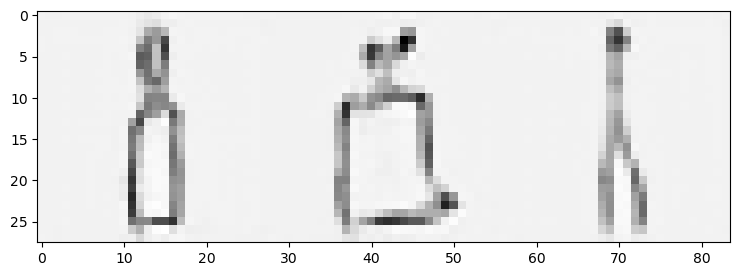

In [229]:
from matplotlib import pyplot as plt
%matplotlib inline

x = model.G(3)
x = tf.concat([x[i, ...] for i in range(3)], axis=1)
plt.figure(figsize=(12, 3))
plt.imshow(x, cmap='binary')
plt.show()

In [226]:
model.D.save_weights('discriminator.pd')
model.G.save_weights('generator.pd')